# Import Libraries

In [9]:
# Standard data manipulation and numerical libraries
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Natural Language Processing (NLP) tools
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Machine Learning preprocessing and evaluation tools
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

# Machine Learning models
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Deep Learning libraries and layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Utility and serialization
from IPython.display import display
import joblib

# Setting up NLTK (uncomment if necessary)
# nltk.download("stopwords")
try:
    stop_words = set(stopwords.words("english"))
    lemmatizer = WordNetLemmatizer()
except LookupError:
    nltk.download("stopwords")
    stop_words = set(stopwords.words("english"))
    lemmatizer = WordNetLemmatizer()

# 1.Dataset Preparation & Preprocessing

In [2]:
# Read datasets
df_dataset = pd.read_csv(r'C:\Users\86138\Desktop\A\ML_Group1\Tweets\Group1\Data\Subdataset\combined_dataset.csv', names=['Emotion', 'Text'], sep=',', skiprows= 1)
df_train = pd.read_csv(r'C:\Users\86138\Desktop\A\ML_Group1\Tweets\Group1\Data\train_data.csv', names=['Emotion', 'Text'], sep=',', skiprows= 1)
df_val = pd.read_csv(r'C:\Users\86138\Desktop\A\ML_Group1\Tweets\Group1\Data\validation_data.csv', names=['Emotion', 'Text'], sep=',', skiprows= 1)
df_test = pd.read_csv(r'C:\Users\86138\Desktop\A\ML_Group1\Tweets\Group1\Data\test_data.csv', names=['Emotion', 'Text'], sep=',', skiprows= 1)

In [3]:
#print first 5 rows
display(df_train.head())
display(df_test.head())
display(df_val.head())

,Emotion,Text
0,joy,i still feel a bit funny
1,love,im feeling calm and ready to get out of this c...
2,sadness,i could feel the horse beneath me hear the lea...
3,joy,i pron high dar ree don t you just love that m...
4,sadness,ive enjoyed and loved everything here all the ...


,Emotion,Text
0,love,i hated the feeling of love as much as i have ...
1,sadness,i am right now when i see elayne i find myself...
2,surprise,i just sat there feeling stunned
3,anger,i would feel so angry alone and cheated
4,anger,i had been feeling irritable and distracted


,Emotion,Text
0,surprise,Crazy ! He locked himself in the room .
1,happiness,i didnt feel that welcomed when i first entere...
2,happiness,i have a feeling that people are using it more...
3,sadness,Nothing . I just feel very lonely in this cit...
4,sadness,im feeling resigned to this down in the dumps ...


In [4]:
print(df_train.shape); print(df_test.shape); print(df_val.shape);print(df_dataset.shape)

(107720, 2)
(13465, 2)
(13465, 2)
(58245, 2)


In [5]:
# Calculate counts
emotion_counts = df_dataset['Emotion'].value_counts()

# Calculate percentages
emotion_percentage = df_dataset['Emotion'].value_counts(normalize=True) * 100

# Combine counts and percentages into a single DataFrame
emotion_summary = pd.DataFrame({
    'Count': emotion_counts,
    'Percentage': emotion_percentage
})

# Display the summary
display(emotion_summary)

,Count,Percentage
Emotion,,
fear,18523,31.801871
surprise,15185,26.070907
anger,11483,19.714997
sadness,9575,16.439179
joy,3000,5.150657
happiness,479,0.822388


In [6]:
#check if the data is balanced or not

# Calculate the percentage of each category in the DataFrames
df_train_percent = df_train.Emotion.value_counts(normalize=True) * 100
df_test_percent = df_test.Emotion.value_counts(normalize=True) * 100
df_val_percent = df_val.Emotion.value_counts(normalize=True) * 100

# Combine these percentages into a new DataFrame
df_combined_percentages = pd.concat([df_train_percent, df_test_percent, df_val_percent], axis=1)

# Set appropriate names for the columns of the combined DataFrame
df_combined_percentages.columns = ['Train', 'Test', 'Validation']

# Display the result
display(df_combined_percentages)

,Train,Test,Validation
Emotion,,,
fear,13.816376,14.311177,13.776457
sadness,13.802451,14.028964,14.207204
joy,13.750464,13.924991,13.613071
anger,13.236168,12.885258,13.249165
love,13.068140,13.457111,12.959525
surprise,12.992945,13.056071,13.397698
happiness,10.169885,9.372447,9.654660
neutral,9.163572,8.963981,9.142221


In [7]:
#showing that all the data is different
print(df_train.duplicated().sum()),
print(df_test.duplicated().sum()),
print(df_val.duplicated().sum())


0
0
0


In [8]:
print(df_train.isnull().sum()),
print(df_test.isnull().sum()),
print(df_val.isnull().sum())

Emotion    0
Text       0
dtype: int64
Emotion    0
Text       0
dtype: int64
Emotion    0
Text       0
dtype: int64


# Data Visualization

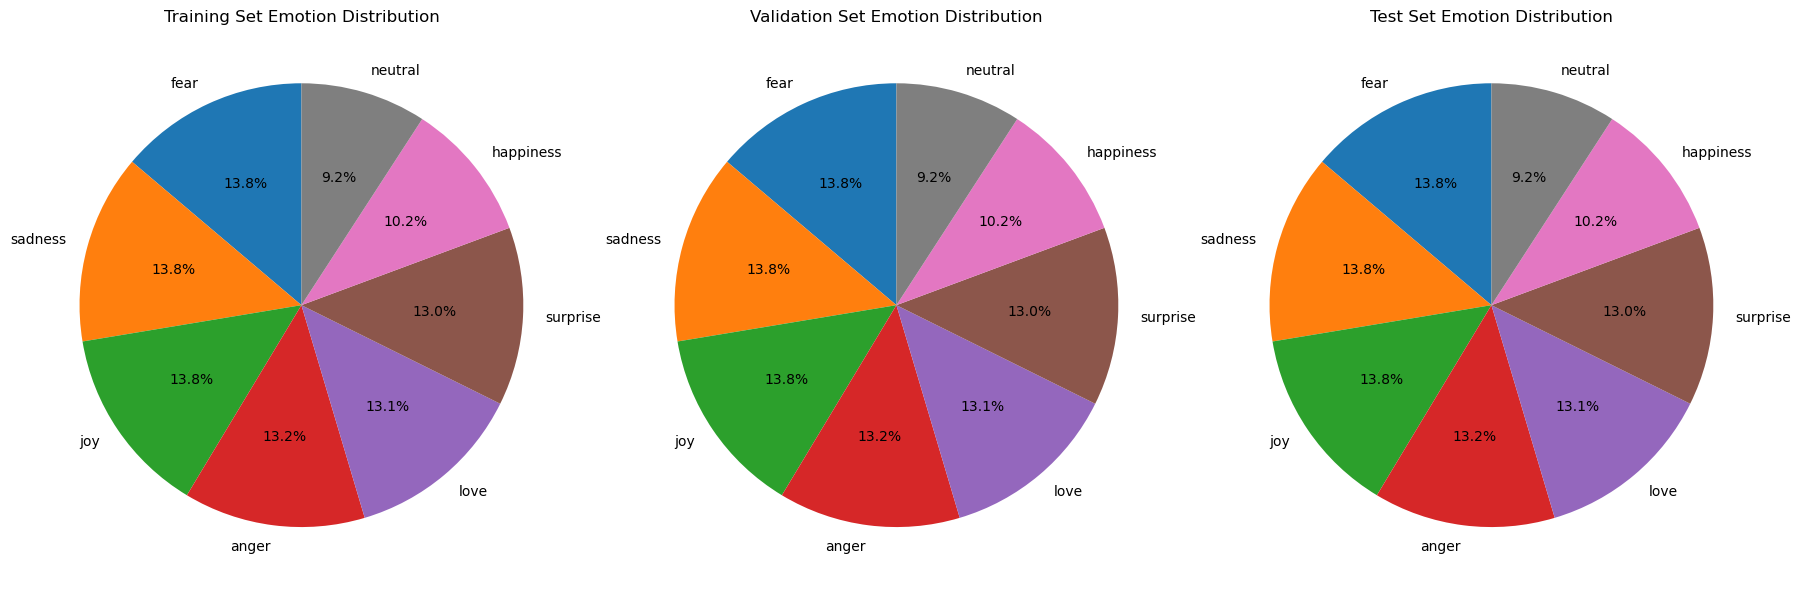

In [9]:
# Function to plot a pie chart for the Emotion column
def plot_pie_chart(data, subplot_title, ax):
    emotion_counts = data['Emotion'].value_counts()
    ax.pie(emotion_counts, labels=emotion_counts.index, autopct='%1.1f%%', startangle=90)
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax.set_title(subplot_title)

# Create a figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # Adjust figsize to fit your display

# Plot pie charts
plot_pie_chart(df_train, 'Training Set Emotion Distribution', axs[0])
plot_pie_chart(df_train, 'Validation Set Emotion Distribution', axs[1])
plot_pie_chart(df_train, 'Test Set Emotion Distribution', axs[2])

# Display the plot
plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()



# Text Processing

In [10]:

# Define the set of stop words, including custom additions
additional_stop_words = {
    'feeling', 'feel', 'im', 'i', 'iam', 'me', 'my', 'myself', 'you', 'your', 'yours',
    'he', 'his', 'she', 'her', 'it', 'its', 'we', 'our', 'us', 'they', 'their', 'them',
    'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'there', 'where',
    'when', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other',
    'some', 'such', 'just', 'like', 'really', 'very', 'so', 'too', 'quite', 'simply'
}
stop_words = set(stopwords.words('english')).union(additional_stop_words)

def normalized_sentence(sentence):
    # Local helper functions
    def lower_case(text):
        return text.lower()

    def removing_numbers(text):
        return ''.join(char for char in text if not char.isdigit())

    def removing_punctuations(text):
        punctuations = """!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""
        modified_punctuations = punctuations.replace("!", "").replace("?", "")
        return re.sub(r'[' + re.escape(modified_punctuations) + ']', ' ', text).strip()

    def removing_urls(text):
        return re.sub(r'https?://\S+|www\.\S+', '', text)

    def remove_stop_words(text):
        return " ".join(word for word in text.split() if word.lower() not in stop_words)

    def lemmatization(text):
        lemmatizer = WordNetLemmatizer()
        return " ".join(lemmatizer.lemmatize(word) for word in text.split())
    
    # Normalization process
    sentence = lower_case(sentence)
    sentence = removing_numbers(sentence)
    sentence = removing_punctuations(sentence)
    sentence = removing_urls(sentence)
    sentence = remove_stop_words(sentence)
    sentence = lemmatization(sentence)
    return sentence

def normalize_text(df, text_column='Text'):
    df[text_column] = df[text_column].apply(normalized_sentence)
    return df


In [21]:
import nltk

try:
    nltk.data.find('wordnet')
    print("Downloaded")
except:
    print("Downloading")
    nltk.download('wordnet')

Downloading


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\86138\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [22]:
df_dataset= normalize_text(df_dataset)
df_train= normalize_text(df_train)
df_test= normalize_text(df_test)
df_val= normalize_text(df_val)

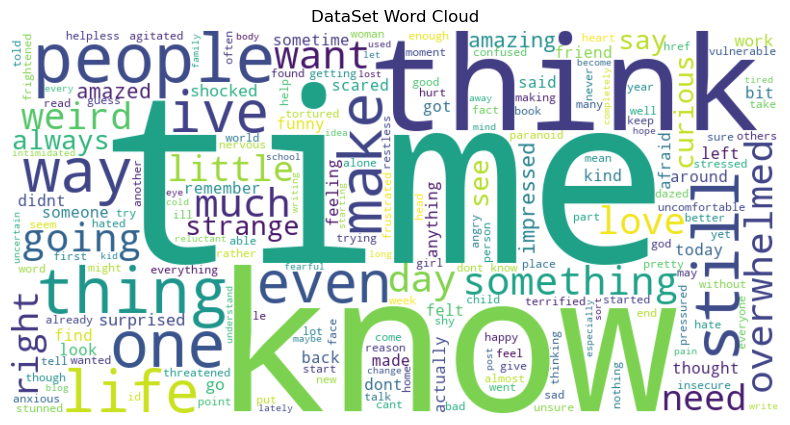

In [15]:
# Function to create and plot a word cloud

def plot_word_cloud(df, title):
    # Combine all text in the dataset
    combined_text = ' '.join(df['Text'].astype(str))
    
    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)
    
    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Plot word clouds for dataset
plot_word_cloud(df_dataset, 'DataSet Word Cloud')

## Baseline Model

In [23]:
#Preprocess text
X_train = df_train['Text'].values
y_train = df_train['Emotion'].values

X_test = df_test['Text'].values
y_test = df_test['Emotion'].values

X_val = df_val['Text'].values
y_val = df_val['Emotion'].values

In [31]:
print(X_train)

['still bit funny'
 'calm ready get comfortable charlottesville bubble go love people serve'
 'could horse beneath hear leather saddle creak horse cantered scared thrilled time'
 ... 'guess dont mind actually love isolated internet outside'
 'admired people good experience carrying love tummy precious fruit love yet tragic sad pregnancy ended way'
 'read give warm fuzzy gone carefree happy day still able relive moment old magazine']


In [24]:

def train_model(model, data, targets):
    """
    Train a model on the given data and targets.
    
    Parameters:
    model (sklearn model): The model to be trained.
    data (list of str): The input data.
    targets (list of str): The targets.
    
    Returns:
    Pipeline: The trained model as a Pipeline object.
    """
    # Create a Pipeline object with a TfidfVectorizer and the given model
    text_clf = Pipeline([('vect',TfidfVectorizer()),
                         ('clf', model)])
    # Fit the model on the data and targets
    text_clf.fit(data, targets)
    return text_clf

def get_F1(trained_model,X,y):
    """
    Get the F1 score for the given model on the given data and targets.
    
    Parameters:
    trained_model (sklearn model): The trained model.
    X (list of str): The input data.
    y (list of str): The targets.
    
    Returns:
    array: The F1 score for each class.
    """
    # Make predictions on the input data using the trained model
    predicted=trained_model.predict(X)
    # Calculate the F1 score for the predictions
    f1=f1_score(y,predicted, average=None)
    # Return the F1 score
    return f1

In [27]:
#Train the DecisionTree model with the training data
DT = train_model(DecisionTreeClassifier(random_state = 0), X_train, y_train)

#test the model with the test data
y_pred=DT.predict(X_test)

#calculate the accuracy
DT_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ', DT_accuracy,'\n')

#calculate the F1 score
f1_Score = get_F1(DT,X_test,y_test)
pd.DataFrame(f1_Score, index=df_train.Emotion.unique(), columns=['F1 score']) 


Accuracy:  0.761901225399183 



,F1 score
joy,0.805300
love,0.769694
sadness,0.870579
neutral,0.630631
surprise,0.882108
anger,0.604855
fear,0.806297
happiness,0.713517


In [28]:
##Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       anger       0.80      0.81      0.81      1735
        fear       0.75      0.80      0.77      1927
   happiness       0.88      0.86      0.87      1262
         joy       0.63      0.63      0.63      1875
        love       0.89      0.88      0.88      1812
     neutral       0.58      0.63      0.60      1207
     sadness       0.81      0.80      0.81      1889
    surprise       0.75      0.68      0.71      1758

    accuracy                           0.76     13465
   macro avg       0.76      0.76      0.76     13465
weighted avg       0.76      0.76      0.76     13465



In [ ]:
#Train the RandomForest model with the training data
RF = train_model(RandomForestClassifier(random_state = 0), X_train, y_train)

#test the model with the test data
y_pred=RF.predict(X_test)

#calculate the accuracy
RF_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ', RF_accuracy,'\n')

#calculate the F1 score
f1_Score = get_F1(RF, X_test, y_test)
pd.DataFrame(f1_Score, index=df_train.Emotion.unique(), columns=['F1 score']) 

In [ ]:
##Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       anger       0.85      0.82      0.84      1735
        fear       0.80      0.82      0.81      1927
   happiness       0.89      0.88      0.88      1262
         joy       0.68      0.64      0.66      1875
        love       0.89      0.91      0.90      1812
     neutral       0.61      0.73      0.66      1207
     sadness       0.85      0.82      0.83      1889
    surprise       0.77      0.73      0.75      1758

    accuracy                           0.79     13465
   macro avg       0.79      0.79      0.79     13465
weighted avg       0.80      0.79      0.79     13465



In [ ]:
#Train the model with the training data
SVM = train_model(SVC(random_state = 0), X_train, y_train)

#test the model with the test data
y_pred=SVM.predict(X_test)

#calculate the accuracy
SVM_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ', SVM_accuracy,'\n')

#calculate the F1 score
f1_Score = get_F1(SVM,X_test,y_test)
pd.DataFrame(f1_Score, index=df_train.Emotion.unique(), columns=['F1 score'])

In [ ]:
##Classification Report
print(classification_report(y_test, y_pred))

In [ ]:
# Save our trained model
joblib.dump(LR, 'Logistic_Regression_model.joblib')
joblib.dump(DT, 'decision_tree_model.joblib')
joblib.dump(RF, 'random_forest_model.joblib')
joblib.dump(SVM, 'support_vector_machine_model.joblib')

['support_vector_machine_model.joblib']

# Using Word Embedding(GloVe) and LSTM

In [18]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2

In [19]:
df_dataset = pd.read_csv(r"C:\Users\86138\Desktop\A\ML_Group1\Tweets\Group1\Data\Subdataset\combined_dataset.csv", names=['Emotion', 'Text'], sep=',', skiprows= 1)
df_train = pd.read_csv(r"C:\Users\86138\Desktop\A\ML_Group1\Tweets\Group1\Data\train_data.csv", names=['Emotion', 'Text'], sep=',', skiprows= 1)
df_val = pd.read_csv(r"C:\Users\86138\Desktop\A\ML_Group1\Tweets\Group1\Data\validation_data.csv", names=['Emotion', 'Text'], sep=',', skiprows= 1)
df_test = pd.read_csv(r"C:\Users\86138\Desktop\A\ML_Group1\Tweets\Group1\Data\test_data.csv", names=['Emotion', 'Text'], sep=',', skiprows= 1)

# 1.Model Training (Glove+ BiGRU)

In [24]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras import regularizers

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import Constant
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, Dense, Dropout


In [25]:

# Load datasets
df_train = pd.read_csv(r"C:\Users\86138\Desktop\A\ML_Group1\Tweets\Group1\Data\train_data.csv", names=['Label', 'Text'], sep=',')
df_val = pd.read_csv(r"C:\Users\86138\Desktop\A\ML_Group1\Tweets\Group1\Data\validation_data.csv", names=['Label', 'Text'], sep=',')
df_test = pd.read_csv(r"C:\Users\86138\Desktop\A\ML_Group1\Tweets\Group1\Data\test_data.csv", names=['Label', 'Text'], sep=',')


In [26]:
# Normalize the text data
df_train = normalize_text(df_train)
df_val = normalize_text(df_val)
df_test = normalize_text(df_test)

# Tokenization parameters
max_words = 100000
max_len = 100
embedding_dim = 200

# Tokenization process
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df_train['Text'])
word_index = tokenizer.word_index

# Convert texts to sequences
train_sequences = tokenizer.texts_to_sequences(df_train['Text'])
val_sequences = tokenizer.texts_to_sequences(df_val['Text'])
test_sequences = tokenizer.texts_to_sequences(df_test['Text'])

# Padding sequences
train_padded = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
val_padded = pad_sequences(val_sequences, maxlen=max_len, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

# Encode labels to categorical format
label_encoder = LabelEncoder()
label_encoder.fit(df_train['Label'])

train_labels = to_categorical(label_encoder.transform(df_train['Label']))
val_labels = to_categorical(label_encoder.transform(df_val['Label']))
test_labels = to_categorical(label_encoder.transform(df_test['Label']))

In [16]:
# Function to load GloVe embeddings
def load_glove_embeddings(path, embedding_dim):
    embeddings_index = {}
    with open(path, 'r', encoding='utf-8') as file:
        for line in file:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

# Load GloVe embeddings
glove_path = r"C:\Users\86138\Desktop\A\ML_Group1\Tweets\Tweets_Data\GloVe\glove.6B.200d.txt"# Path to GloVe embeddings
embeddings_index = load_glove_embeddings(glove_path, embedding_dim)

# Create embedding matrix
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector


In [14]:
# Define the model
model = Sequential([
    Embedding(max_words, embedding_dim, embeddings_initializer=Constant(embedding_matrix), input_length=max_len, trainable=False),
    Bidirectional(GRU(128, return_sequences=True)),
    Bidirectional(GRU(64)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(df_train['Label'].unique()), activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(train_padded, train_labels, epochs=10, validation_data=(val_padded, val_labels), batch_size=32)


C:\Users\86138\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
3367/3367 ━━━━━━━━━━━━━━━━━━━━ 799s 230ms/step - accuracy: 0.6838 - loss: 0.9307 - val_accuracy: 0.8358 - val_loss: 0.4770
Epoch 2/10
3367/3367 ━━━━━━━━━━━━━━━━━━━━ 614s 182ms/step - accuracy: 0.8301 - loss: 0.5079 - val_accuracy: 0.8461 - val_loss: 0.4332
Epoch 3/10
3367/3367 ━━━━━━━━━━━━━━━━━━━━ 399s 119ms/step - accuracy: 0.8481 - loss: 0.4388 - val_accuracy: 0.8481 - val_loss: 0.4267
Epoch 4/10
3367/3367 ━━━━━━━━━━━━━━━━━━━━ 411s 122ms/step - accuracy: 0.8565 - loss: 0.4001 - val_accuracy: 0.8498 - val_loss: 0.4237
Epoch 5/10
3367/3367 ━━━━━━━━━━━━━━━━━━━━ 377s 112ms/step - accuracy: 0.8643 - loss: 0.3714 - val_accuracy: 0.8518 - val_loss: 0.4327
Epoch 6/10
3367/3367 ━━━━━━━━━━━━━━━━━━━━ 380s 113ms/step - accuracy: 0.8730 - loss: 0.3388 - val_accuracy: 0.8495 - val_loss: 0.4524
Epoch 7/10
3367/3367 ━━━━━━━━━━━━━━━━━━━━ 394s 117ms/step - accuracy: 0.8789 - loss: 0.3144 - val_accuracy: 0.8478 - val_loss: 0.4707
Epoch 8/10
3367/3367 ━━━━━━━━━━━━━━━━━━━━ 393s 117ms/step - ac

In [ ]:
test_loss, test_acc = model.evaluate(test_padded, test_labels)
print("Test Accuracy: ", test_acc)

421/421 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.8378 - loss: 0.6076
Test Accuracy:  0.8441259264945984


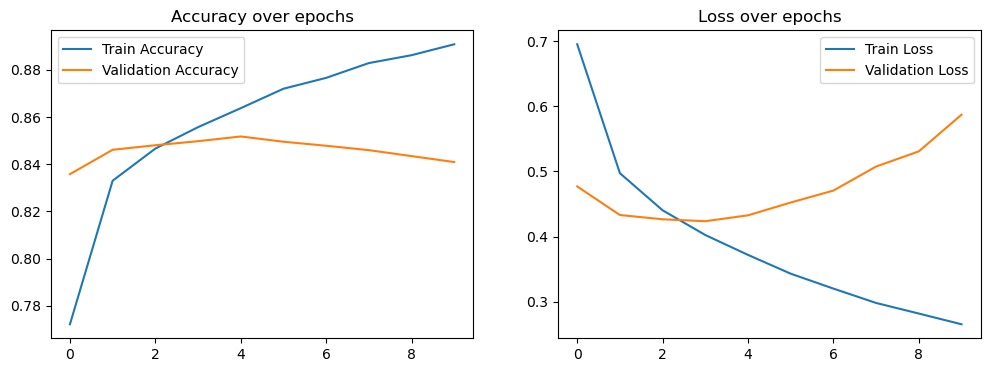

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.legend()
plt.show()


# Second Time

In [51]:
# 定义模型
model = Sequential([
    Embedding(max_words, embedding_dim, embeddings_initializer=Constant(embedding_matrix), input_length=max_len, trainable=False),
    Bidirectional(GRU(128, return_sequences=False)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),  # 添加L2正则化
    Dropout(0.4),  # Dropout比例调整为0.4
    Dense(len(df_train['Label'].unique()), activation='softmax')
])

# 编译模型
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])  # 学习率调整为0.001

# 引入早停法
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# 训练模型
history = model.fit(train_padded, train_labels, epochs=5, validation_data=(val_padded, val_labels), batch_size=32, callbacks=[early_stopping])


Epoch 1/5
3367/3367 ━━━━━━━━━━━━━━━━━━━━ 234s 66ms/step - accuracy: 0.6625 - loss: 1.1470 - val_accuracy: 0.8260 - val_loss: 0.5683
Epoch 2/5
3367/3367 ━━━━━━━━━━━━━━━━━━━━ 226s 67ms/step - accuracy: 0.8197 - loss: 0.5924 - val_accuracy: 0.8385 - val_loss: 0.5156
Epoch 3/5
3367/3367 ━━━━━━━━━━━━━━━━━━━━ 232s 69ms/step - accuracy: 0.8344 - loss: 0.5328 - val_accuracy: 0.8424 - val_loss: 0.4962
Epoch 4/5
3367/3367 ━━━━━━━━━━━━━━━━━━━━ 224s 67ms/step - accuracy: 0.8432 - loss: 0.4956 - val_accuracy: 0.8400 - val_loss: 0.4941
Epoch 5/5
3367/3367 ━━━━━━━━━━━━━━━━━━━━ 226s 67ms/step - accuracy: 0.8520 - loss: 0.4687 - val_accuracy: 0.8443 - val_loss: 0.4952


In [52]:
test_loss, test_acc = model.evaluate(test_padded, test_labels)
print("Test Accuracy: ", test_acc)

421/421 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.8426 - loss: 0.4946
Test Accuracy:  0.8434575796127319


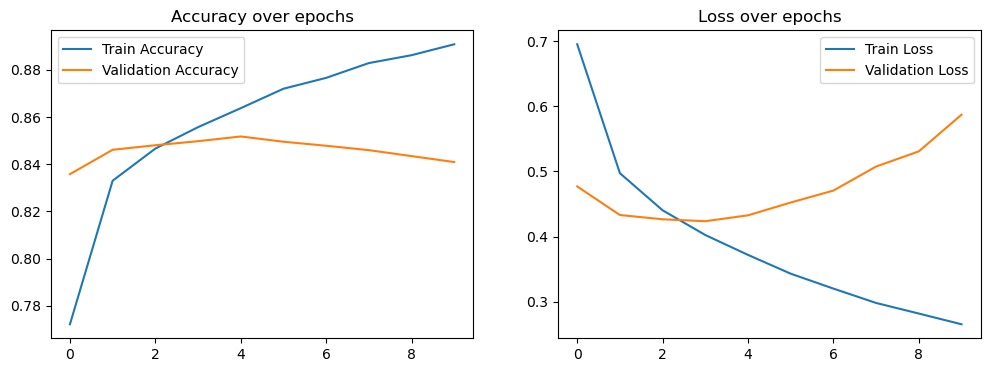

In [45]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.legend()
plt.show()

### Transformer Model

In [42]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, MultiHeadAttention, LayerNormalization, Dense, Dropout, GlobalAveragePooling1D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import Constant

In [46]:
inputs = Input(shape=(max_len,))
x = Embedding(max_words, embedding_dim, embeddings_initializer=Constant(embedding_matrix), input_length=max_len, trainable=False)(inputs)
attention_output = MultiHeadAttention(num_heads=8, key_dim=embedding_dim, dropout=0.2)(x, x)  # query, key, value 都是 x
attention_output = LayerNormalization()(attention_output)

ffn_output = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(attention_output)
ffn_output = Dense(embedding_dim)(ffn_output)  # 将维度恢复到embedding_dim
ffn_output = LayerNormalization()(ffn_output)
x = GlobalAveragePooling1D()(ffn_output)
x = Dropout(0.4)(x)

output = Dense(len(df_train['Label'].unique()), activation='softmax')(x)
model2 = Model(inputs=inputs, outputs=output)

model2.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
history = model2.fit(train_padded, train_labels, epochs=5, validation_data=(val_padded, val_labels), batch_size=32, callbacks=[early_stopping])

Epoch 1/5
3367/3367 ━━━━━━━━━━━━━━━━━━━━ 485s 143ms/step - accuracy: 0.6883 - loss: 1.2642 - val_accuracy: 0.8185 - val_loss: 0.5695
Epoch 2/5
3367/3367 ━━━━━━━━━━━━━━━━━━━━ 497s 148ms/step - accuracy: 0.8213 - loss: 0.5542 - val_accuracy: 0.8245 - val_loss: 0.5447
Epoch 3/5
3367/3367 ━━━━━━━━━━━━━━━━━━━━ 489s 145ms/step - accuracy: 0.8305 - loss: 0.5100 - val_accuracy: 0.8371 - val_loss: 0.5099
Epoch 4/5
3367/3367 ━━━━━━━━━━━━━━━━━━━━ 500s 148ms/step - accuracy: 0.8346 - loss: 0.4894 - val_accuracy: 0.8382 - val_loss: 0.4934
Epoch 5/5
3367/3367 ━━━━━━━━━━━━━━━━━━━━ 499s 148ms/step - accuracy: 0.8348 - loss: 0.4807 - val_accuracy: 0.8394 - val_loss: 0.4982


In [55]:
test_loss, test_acc = model2.evaluate(test_padded, test_labels)
print("Test Accuracy: ", test_acc)

421/421 ━━━━━━━━━━━━━━━━━━━━ 47s 111ms/step - accuracy: 0.8393 - loss: 0.4985
Test Accuracy:  0.843086302280426


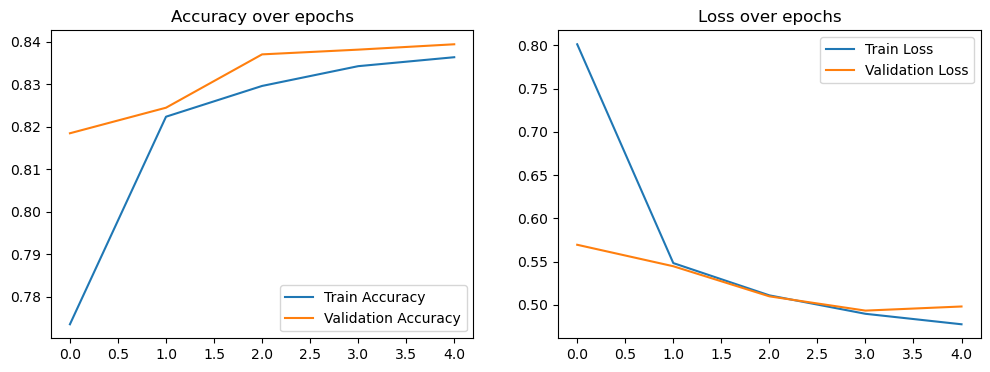

In [50]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.legend()
plt.show()

### Second Times

In [53]:
inputs = Input(shape=(max_len,))
x = Embedding(max_words, embedding_dim, embeddings_initializer=Constant(embedding_matrix), input_length=max_len, trainable=False)(inputs)
attention_output = MultiHeadAttention(num_heads=16, key_dim=embedding_dim, dropout=0.3)(x, x)  # query, key, value 都是 x
attention_output = LayerNormalization()(attention_output)

ffn_output = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(attention_output)
ffn_output = Dense(embedding_dim)(ffn_output)  
ffn_output = LayerNormalization()(ffn_output)
x = GlobalAveragePooling1D()(ffn_output)
x = Dropout(0.4)(x)

output = Dense(len(df_train['Label'].unique()), activation='softmax')(x)
model2 = Model(inputs=inputs, outputs=output)

model2.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
history = model2.fit(train_padded, train_labels, epochs=5, validation_data=(val_padded, val_labels), batch_size=32, callbacks=[early_stopping])

Epoch 1/5
3367/3367 ━━━━━━━━━━━━━━━━━━━━ 925s 274ms/step - accuracy: 0.6831 - loss: 1.0211 - val_accuracy: 0.8374 - val_loss: 0.5206
Epoch 2/5
3367/3367 ━━━━━━━━━━━━━━━━━━━━ 929s 276ms/step - accuracy: 0.8277 - loss: 0.5207 - val_accuracy: 0.8371 - val_loss: 0.5177
Epoch 3/5
3367/3367 ━━━━━━━━━━━━━━━━━━━━ 932s 277ms/step - accuracy: 0.8340 - loss: 0.4917 - val_accuracy: 0.8380 - val_loss: 0.4976
Epoch 4/5
3367/3367 ━━━━━━━━━━━━━━━━━━━━ 937s 278ms/step - accuracy: 0.8403 - loss: 0.4670 - val_accuracy: 0.8443 - val_loss: 0.4827
Epoch 5/5
3367/3367 ━━━━━━━━━━━━━━━━━━━━ 947s 281ms/step - accuracy: 0.8447 - loss: 0.4433 - val_accuracy: 0.8463 - val_loss: 0.4741


In [56]:
test_loss, test_acc = model2.evaluate(test_padded, test_labels)
print("Test Accuracy: ", test_acc)

421/421 ━━━━━━━━━━━━━━━━━━━━ 40s 96ms/step - accuracy: 0.8393 - loss: 0.4985
Test Accuracy:  0.843086302280426


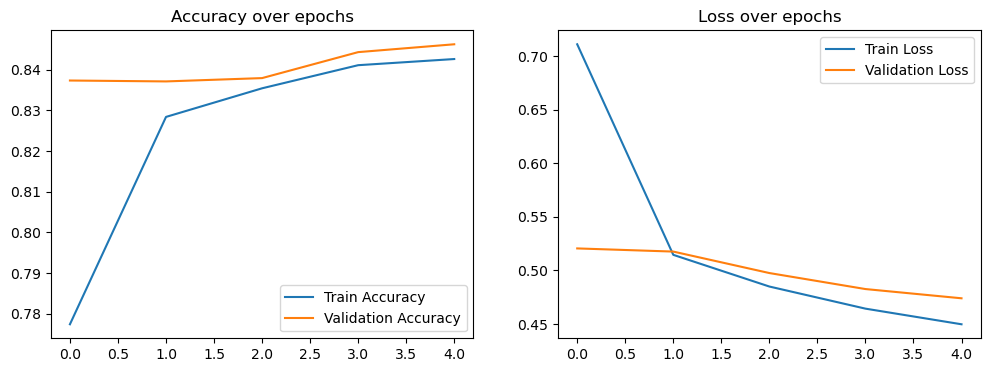

In [57]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.legend()
plt.show()

In [58]:
# 保存 tokenizer 的配置信息
import json
with open("tokenizer_config.json", "w") as tokenizer_file:
    json.dump(tokenizer.word_index, tokenizer_file)

# 保存 Label Encoder 的配置信息
np.save("label_classes.npy", label_encoder.classes_)

# Save the entire model to an HDF5 file
model2.save("transformer_classification_model.h5")


In [59]:
import json
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

def load_model_and_components():
    # 载入模型
    model = tf.keras.models.load_model("transformer_classification_model.h5")
    
    # 载入 tokenizer 配置
    with open("tokenizer_config.json", "r") as tokenizer_file:
        word_index = json.load(tokenizer_file)
    
    tokenizer = Tokenizer(num_words=100000, oov_token="<OOV>")
    tokenizer.word_index = word_index  # 手动恢复 word_index
    
    # 载入 Label Encoder 配置
    label_classes = np.load("label_classes.npy", allow_pickle=True)
    label_encoder = LabelEncoder()
    label_encoder.classes_ = label_classes
    
    return model, tokenizer, label_encoder

def prepare_data(new_texts, tokenizer, max_len):
    new_sequences = tokenizer.texts_to_sequences(new_texts)
    new_padded = pad_sequences(new_sequences, maxlen=max_len)
    return new_padded

def make_prediction(model, prepared_data):
    return model.predict(prepared_data)

def interpret_predictions(predictions, label_encoder):
    predicted_classes = np.argmax(predictions, axis=1)
    return label_encoder.inverse_transform(predicted_classes)

def predict_new_texts(model, tokenizer, new_texts, max_len, label_encoder):
    prepared_data = prepare_data(new_texts, tokenizer, max_len)
    predictions = make_prediction(model, prepared_data)
    return interpret_predictions(predictions, label_encoder)




In [60]:
# 用法示例
model, tokenizer, label_encoder = load_model_and_components()

In [61]:
new_texts = ["sad", "what?"]
predicted_labels = predict_new_texts(model, tokenizer, new_texts, max_len, label_encoder)

print(predicted_labels)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
['sadness' 'neutral']


In [66]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from sklearn.metrics import classification_report

# Load model, tokenizer, and label encoder
model, tokenizer, label_encoder = load_model_and_components()

# Load test dataset
test_data_path = "C:/Users/86138/Desktop/A/ML_Group1/Tweets/Group1/Data/test_data.csv"
test_data = pd.read_csv(test_data_path)

# Assuming your CSV has columns 'text' for the texts and 'label' for the true labels
texts = test_data['text'].tolist()
true_labels = test_data['label'].tolist()

# Define the maximum sequence length used during model training
max_len = 100  # Change this to the max length used during your training

def predict_new_texts(model, tokenizer, new_texts, max_len):
    new_sequences = tokenizer.texts_to_sequences(new_texts)
    new_padded = pad_sequences(new_sequences, maxlen=max_len)
    predictions = model.predict(new_padded)
    return np.argmax(predictions, axis=1)  # Return index of maximum values

def get_classification_report(model, tokenizer, true_labels, texts, max_len, label_encoder):
    predicted_indices = predict_new_texts(model, tokenizer, texts, max_len)
    predicted_labels = label_encoder.inverse_transform(predicted_indices)
    print(classification_report(true_labels, predicted_labels))

# Generate and print the classification report
get_classification_report(model2, tokenizer, true_labels, texts, max_len, label_encoder)

421/421 ━━━━━━━━━━━━━━━━━━━━ 31s 74ms/step
              precision    recall  f1-score   support

       anger       0.93      0.83      0.88      1735
        fear       0.90      0.84      0.87      1927
   happiness       0.88      0.98      0.93      1262
         joy       0.76      0.67      0.71      1875
        love       0.90      0.96      0.93      1812
     neutral       0.60      0.79      0.68      1207
     sadness       0.90      0.85      0.87      1889
    surprise       0.83      0.83      0.83      1758

    accuracy                           0.84     13465
   macro avg       0.84      0.84      0.84     13465
weighted avg       0.85      0.84      0.84     13465

